In [1]:
import os
import time

# Third-party library imports
import numpy as np
import pandas as pd
import cv2
import pydicom
import dicomsdl

# Visualization library imports
import matplotlib.pyplot as plt

# Progress bar library imports
from tqdm.notebook import tqdm, trange

# Parallel processing library imports
from joblib import Parallel, delayed

import gc

In [114]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
#         self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
#         self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
#         if csv_path:
#             self.csv_path = csv_path
#         if train_path:
#             self.train_path = train_path
#         self.df = pd.read_csv(self.csv_path)
        self.save_root = os.getcwd()
    
#     # Get the paths from the preprocessor (V2)
#     def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
#         if n == None:
#             n = len(self.df)
#         if shuffle == True:
#             df = self.df.sample(frac=1, random_state=0).copy()
#         else:
#             df = self.df.copy()
#         paths = []
#         ids_cache = []
#         for i in range(n):
#             patient = str(df.iloc[i]['patient_id'])
#             scan = str(df.iloc[i]['image_id'])
#             paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
#             ids_cache.append({'patient_id': patient, 'scan_id': scan})
#         if return_cache:
#             return paths, ids_cache
#         else:
#             return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    

    def apply_canny(self,image):
        from skimage.feature import canny
        from skimage.filters import sobel
        canny_img = canny(image, .0001)
#         plt.imshow(canny_img)
        return sobel(canny_img)
    
    
    
    def get_hough_lines(self,canny_img):
        from skimage.transform import hough_line, hough_line_peaks
        h, theta, d = hough_line(canny_img)
        lines = list()
#         print('\nAll hough lines')
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#             print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
            x1 = 0
            y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
            x2 = canny_img.shape[1]
            y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
            lines.append({
                'dist': dist,
                'angle': np.degrees(angle),
                'point1': [x1, y1],
                'point2': [x2, y2]
            })
        return lines
    
    
    def shortlist_lines(self,lines):
        MIN_ANGLE = 10
        MAX_ANGLE = 80
        MIN_DIST  = 5
        MAX_DIST  = 6000
        shortlisted_lines = [x for x in lines if 
                              (x['dist']>=MIN_DIST) &
                              (x['dist']<=MAX_DIST) &
                              (x['angle']>=MIN_ANGLE) &
                              (x['angle']<=MAX_ANGLE)
                            ]
#         print('\nShorlisted lines')
#         for i in shortlisted_lines:
#             print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        return shortlisted_lines
    
    
    
    def remove_pectoral(self,shortlisted_lines,img):
        from skimage.draw import polygon
#         print (shortlisted_lines)
        shortlisted_lines.sort(key = lambda x: x['dist'])
#         try:
        pectoral_line = shortlisted_lines[0]
        if pectoral_line['dist'] > np.max([img.shape[0],img.shape[1]]):
            d = pectoral_line['dist']*.3
        else:
            d = pectoral_line['dist']*.7
        theta = np.radians(pectoral_line['angle'])   
        x_intercept = d/np.cos(theta)
        y_intercept = d/np.sin(theta)    
        return polygon([0, 0, y_intercept], [0, x_intercept, 0])


    ##################################################################
    ########## Single Image Preprocessing Final Function #############
    ##################################################################
    # Apply the preprocessing methods on one image
    def preprocess_single_image(self, path: str, save: bool=False,
                                save_dir: str=None, png: bool=True):
        scan = dicomsdl.open(path)
        img = scan.pixelData()
        dim=(img.shape[0],img.shape[1])
        n=.04
        img = self._fix_photometric_interpretation(img, scan)
        #img = self._normalize_to_255(img)
        img=255*(img/np.max(img))
        img = img[int(0+dim[0]*n*1.5):int(dim[0]-dim[0]*n*1.5),int(0+dim[1]*n):int(dim[1]-dim[1]*n)].astype('uint8')
        breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
#         img=remove_pectoral( img, breast_mask, high_int_threshold=.99, 
#                     morph_kn_size=40, n_morph_op=10, sm_kn_size=40)
#         img = self._windowing(img, scan)
        
        img = self._flip_breast_side(img)
        img = self._crop(img)
        
        
        if 'MLO' in path:          
            canny = self.apply_canny(img)
            line = self.get_hough_lines(canny)
            short = self.shortlist_lines(line)
            try:
                rr, cc = self.remove_pectoral(short,img)
    #             plt.plot(rr,cc)
                img[rr, cc] = 0
                breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
                img = self._crop(img)
            except:
                print ("removal didn't work")
#         breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
#         img = self._crop(img)
        
        clahe = cv2.createCLAHE(clipLimit = 8,tileGridSize=(12,12))
        img = clahe.apply(img)
        
        if self.size:
            img = self._resize(img)

        img=(img-np.min(img))/(np.max(img)-np.min(img))*255
        img=img.astype('uint8')
        img=np.expand_dims(img, 2)
        img=np.tile(img, [1,1,3])
        from scipy import stats as st
        mode = st.mode(st.mode(img)[0][0])[0][0][0]
        img[img<=mode]=0
        return img
    

    
#     # Adjust the contrast of an image
#     def _windowing(self, img, scan):
#         center = (2**8-1)-60
#         width = 60
#         bits_stored = scan.BitsStored
#         function = scan.VOILUTFunction
#         if isinstance(center, list):
#             center = center[0]
#         if isinstance(width, list):
#             width = width[0] 
#         y_range = float(2**bits_stored - 1)
#         if function == 'SIGMOID':
#             img = y_range / (1 + np.exp(-4 * (img - center) / width))
#         else: # LINEAR
#             center -= 0.5
#             width -= 1
#             below = img <= (center - width / 2)
#             above = img > (center + width / 2)
#             between = np.logical_and(~below, ~above)
#             img[below] = 0
#             img[above] = y_range
#             img[between] = ((img[between] - center) / width + 0.5) * y_range
#         return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img
        else:
            return np.fliplr(img)    
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        try:
            bin_img = self._binarize(img, threshold=1)
            contour = self._extract_contour(bin_img)
            img = self._erase_background(img, contour)
            x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
            y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
#             x1, x2 = int(0.99 * x1), int(1.01 * x2)
#             y1, y2 = int(0.99 * y1), int(1.01 * y2)
            return img[y1:y2, x1:x2]
        except:
            print ('crop didnt work')
            return img
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img):
        return cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)
    
    # Get the save path of a given dicom file
    def _get_save_path(self, path, png, save_dir):
        patient = path.split('/')[-2]
        filename = path.split('/')[-1]
        if png:
            filename = filename.replace('dcm', 'png')
        else:
            filename = filename.replace('dcm', 'jpeg')
        if save_dir:
            save_path = os.path.join(self.save_root, save_dir, patient, filename)
        else:
            save_path = os.path.join(self.save_root, patient, filename)
        return save_path
    
    # Save the preprocessed image
    def _save_image(self, img, path, png, save_dir):
        save_path = self._get_save_path(path, png, save_dir)
        patient_folder = os.path.split(save_path)[0]
        os.makedirs(patient_folder, exist_ok=True)
        cv2.imwrite(save_path, img)

In [115]:
mp = MammographyPreprocessor(size=(300, 500))

In [116]:
#import torch
img = mp.preprocess_single_image(path=path, save=False)

removal didn't work


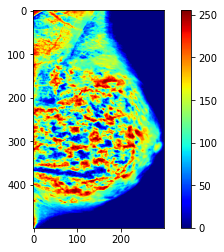

array([[[240, 240, 240],
        [236, 236, 236],
        [237, 237, 237],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[243, 243, 243],
        [236, 236, 236],
        [235, 235, 235],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[236, 236, 236],
        [234, 234, 234],
        [234, 234, 234],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[211, 211, 211],
        [193, 193, 193],
        [163, 163, 163],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[202, 202, 202],
        [179, 179, 179],
        [141, 141, 141],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[190, 190, 190],
        [157, 157, 157],
        [129, 129, 129],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [117]:
plt.imshow(img[:,:,0], cmap='jet')
plt.colorbar()
plt.show()
from scipy import stats as st
img

In [108]:
np.max(img)

255

# Run this to convert Dicom to PNG

In [118]:
import warnings
warnings.filterwarnings("ignore")
mp = MammographyPreprocessor(size=(300, 500))
PNG = False
# !pip install dicom
import pydicom as dicom
# Specify the .dcm folder path
folder_path = "F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/"
# Specify the output jpg/png folder path
jpg_folder_path = "C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v4_3d"
folders=os.listdir(folder_path)
count=1
for i in folders:
    if 'LICENSE' in i:
        continue
    else:
        #if 'Test' in i:
        folder1=os.listdir(os.path.join(folder_path, i))
        folder2 = os.listdir(os.path.join(folder_path, i,folder1[0]))
        if "mammogram" in folder2[0]:
            images_path=os.listdir(os.path.join(folder_path, i,folder1[0],folder2[0]))
            #print (images_path)
            try:
                os.makedirs(os.path.join(jpg_folder_path,i))
            except:
                continue
            for image in images_path:
                path=os.path.join(folder_path, i,folder1[0],folder2[0],image)
                pixel_array_numpy = mp.preprocess_single_image(path=path, save=False)
#                 ds = dicom.dcmread(os.path.join(folder_path, i,folder1[0],folder2[0],image))
#                 pixel_array_numpy = ds.pixel_array
#                 pixel_array_numpy = (pixel_array_numpy/np.max(pixel_array_numpy))*255
                
#                 pixel_array_numpy = preprocess(pixel_array_numpy)
                if PNG == False:
                    image = image.replace('.dcm', '.jpg')
                else:
                    image = image.replace('.dcm', '.png')

                cv2.imwrite(os.path.join(jpg_folder_path,i, image), pixel_array_numpy)


removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work


removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work


removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work
removal didn't work


In [101]:
def preprocess(image):
    #image = cv2.resize(image, (1200, 1600),interpolation = cv2.INTER_CUBIC)
    dim=(image.shape[0],image.shape[1])
    n=.05
    image = image[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)].astype('uint8')
    image=suppress_artifacts(image)
#     mask_img = OpenMask(mask=image, ksize=(20, 20), operation="open")
#     blob_img=select_largest_obj(mask_img)
#     #_, blob_img = np.array(XLargestBlobs(mask=mask_img, top_X=1))
#     image[blob_img==0]=0
#     if np.mean(np.where(image[int(dim[1]*.4),:]>20)) > dim[0]*.4:
#         image=np.fliplr(image)
#     image=segment_breast(image,low_int_threshold=.1, crop=True)
    
    #image=image[:,:-40]
#     image = cv2.resize(image, (300, 500),interpolation = cv2.INTER_AREA)
#     clahe = cv2.createCLAHE(clipLimit = 4,tileGridSize=(12,12))
#     image = clahe.apply(image)
#     #image = (image/np.max(image))*255
#     #image = image.astype('uint8')
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image
    

In [3]:
def OpenMask(mask, ksize=(23, 23), operation="open"):
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)    
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    return edited_mask

def SortContoursByArea(contours, reverse=True):   
    '''
    ----------
    contours : {list}
        The list of contours to sort.        
    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    '''   
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)    
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    return sorted_contours, bounding_boxes

def DrawContourID(img, bounding_box, contour_id):    
    '''
    ----------
    img: {numpy.ndarray}
        The image to draw the contour on.
    bounding_box : {tuple of int}
        The bounding_rect of the given contour.
    contour_id : {int or float}
        The corresponding ID of the given `contour`.        
    Returns
    -------
    img : {numpy.ndarray}
        The image after the `contour` and its ID is drawn on.
    ''' 
    # Center of bounding_rect.
    x, y, w, h = bounding_box
    center = ( ((x + w) // 2), ((y + h) // 2) )
    # Draw the countour number on the image
    cv2.putText(img=img,
                text=f"{contour_id}",
                org=center, # Bottom-left corner of the text string in the image.
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=10, 
                color=(255, 255, 255),
                thickness=40)
    return img

def XLargestBlobs(mask, top_X=None):
    
    '''
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_X : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.
    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    '''        
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(image=mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)   
    n_contours = len(contours)    
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:        
        # Make sure that the number of contours to keep is at most equal 
        # to the number of contours present in the mask.
        if n_contours < top_X or top_X == None:
            top_X = n_contours        
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = SortContoursByArea(contours=contours,
                                                             reverse=True)        
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_X]        
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)        
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(image=to_draw_on, # Draw the contours on `to_draw_on`.
                                           contours=X_largest_contours, # List of contours to draw.
                                           contourIdx=-1, # Draw all contours in `contours`.
                                           color=1, # Draw the contours in white.
                                           thickness=-1) # Thickness of the contour lines.        
    return n_contours, X_largest_blobs

In [4]:
import cv2
import numpy as np





def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin (2D array): 2D numpy array of binary image.
        lab_val ([int]): integer value used for the label of the largest 
                object. Default is 255.
        fill_holes ([boolean]): whether fill the holes inside the largest 
                object or not. Default is false.
        smooth_boundary ([boolean]): whether smooth the boundary of the 
                largest object using morphological opening or not. Default 
                is false.
        kernel_size ([int]): the size of the kernel used for morphological 
                operation. Default is 15.
    Returns:
        a binary image as a mask for the largest object.
    '''
    n_labels, img_labeled, lab_stats, _ = \
        cv2.connectedComponentsWithStats(img_bin, connectivity=8, 
                                         ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    # import pdb; pdb.set_trace()
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, 
                      newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, 
                                        kernel_)

    return largest_mask


def max_pix_val(dtype):
    if dtype == np.dtype('uint8'):
        maxval = 2**8 - 1
    elif dtype == np.dtype('uint16'):
        maxval = 2**16 - 1
    else:
        raise Exception('Unknown dtype found in input image array')
    return maxval


def suppress_artifacts( img, global_threshold=.05, fill_holes=False, 
                       smooth_boundary=True, kernel_size=15):
    '''Mask artifacts from an input image
    Artifacts refer to textual markings and other small objects that are 
    not related to the breast region.
    Args:
        img (2D array): input image as a numpy 2D array.
        global_threshold ([int]): a global threshold as a cutoff for low 
                intensities for image binarization. Default is 18.
        kernel_size ([int]): kernel size for morphological operations. 
                Default is 15.
    Returns:
        a tuple of (output_image, breast_mask). Both are 2D numpy arrays.
    '''
    maxval = max_pix_val(img.dtype)
    if global_threshold < 1.:
        low_th = int(img.max()*global_threshold)
    else:
        low_th = int(global_threshold)
    _, img_bin = cv2.threshold(img, low_th, maxval=maxval, 
                               type=cv2.THRESH_BINARY)
    breast_mask = select_largest_obj(img_bin, lab_val=maxval, 
                                          fill_holes=True, 
                                          smooth_boundary=True, 
                                          kernel_size=kernel_size)
    img_suppr = cv2.bitwise_and(img, breast_mask)

    return img_suppr


def segment_breast(img, low_int_threshold=.05, crop=True):
    '''Perform breast segmentation
    Args:
        low_int_threshold([float or int]): Low intensity threshold to 
                filter out background. It can be a fraction of the max 
                intensity value or an integer intensity value.
        crop ([bool]): Whether or not to crop the image.
    Returns:
        An image of the segmented breast.
    NOTES: the low_int_threshold is applied to an image of dtype 'uint8',
        which has a max value of 255.
    '''
    # Create img for thresholding and contours.
    img_8u = (img.astype('float32')/img.max()*255).astype('uint8')
    if low_int_threshold < 1.:
        low_th = int(img_8u.max()*low_int_threshold)
    else:
        low_th = int(low_int_threshold)
    _, img_bin = cv2.threshold(
        img_8u, low_th, maxval=255, type=cv2.THRESH_BINARY)
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        contours,_ = cv2.findContours(
            img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,_ = cv2.findContours(
            img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_areas = [ cv2.contourArea(cont) for cont in contours ]
    idx = np.argmax(cont_areas)  # find the largest contour, i.e. breast.
    breast_mask = cv2.drawContours(
        np.zeros_like(img_bin), contours, idx, 255, -1)  # fill the contour.
#     # segment the breast.
#     img_breast_only = cv2.bitwise_and(img, img, mask=breast_mask)
#     x,y,w,h = cv2.boundingRect(contours[idx])
#     if crop:
#         img_breast_only = img_breast_only[y:y+h, x:x+w]
    return  breast_mask


def remove_pectoral( img, breast_mask, high_int_threshold=.8, 
                    morph_kn_size=3, n_morph_op=7, sm_kn_size=25):
    '''Remove the pectoral muscle region from an input image
    Args:
        img (2D array): input image as a numpy 2D array.
        breast_mask (2D array):
        high_int_threshold ([int]): a global threshold for high intensity 
                regions such as the pectoral muscle. Default is 200.
        morph_kn_size ([int]): kernel size for morphological operations 
                such as erosions and dilations. Default is 3.
        n_morph_op ([int]): number of morphological operations. Default is 7.
        sm_kn_size ([int]): kernel size for final smoothing (i.e. opening). 
                Default is 25.
    Returns:
        an output image with pectoral muscle region removed as a numpy 
        2D array.
    Notes: this has not been tested on .dcm files yet. It may not work!!!
    '''
    # Enhance contrast and then thresholding.
    img_equ = cv2.equalizeHist(img)
    if high_int_threshold < 1.:
        high_th = int(img.max()*high_int_threshold)
    else:
        high_th = int(high_int_threshold)
    maxval = max_pix_val(img.dtype)
    _, img_bin = cv2.threshold(img_equ, high_th, 
                               maxval=maxval, type=cv2.THRESH_BINARY)
    pect_marker_img = np.zeros(img_bin.shape, dtype=np.int32)
    # Sure foreground (shall be pectoral).
    pect_mask_init = select_largest_obj(img_bin, lab_val=maxval, 
                                             fill_holes=True, 
                                             smooth_boundary=False)
    kernel_ = np.ones((morph_kn_size, morph_kn_size), dtype=np.uint8)
    pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, 
                                 iterations=n_morph_op)
    pect_marker_img[pect_mask_eroded > 0] = 255
    # Sure background - breast.
    pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, 
                                   iterations=n_morph_op)
    pect_marker_img[pect_mask_dilated == 0] = 128
    # Sure background - pure background.
    pect_marker_img[breast_mask == 0] = 64
    # Watershed segmentation.
    img_equ_3c = cv2.cvtColor(img_equ, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_equ_3c, pect_marker_img)
    img_equ_3c[pect_marker_img == -1] = (0, 0, 255)
    # Extract only the breast and smooth.
    breast_only_mask = pect_marker_img.copy()
    breast_only_mask[breast_only_mask == -1] = 0
    breast_only_mask = breast_only_mask.astype(np.uint8)
    breast_only_mask[breast_only_mask != 128] = 0
    breast_only_mask[breast_only_mask == 128] = 255
    kernel_ = np.ones((sm_kn_size, sm_kn_size), dtype=np.uint8)
    breast_only_mask = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, 
                                        kernel_)
    img_breast_only = cv2.bitwise_and(img_equ, breast_only_mask)

    return (img_breast_only)


def process(self, img, median_filtering=True, blur_kn_size=3, 
            artif_suppression=True, low_int_threshold=.05, kernel_size=15,
            pect_removal=False, high_int_threshold=.8, **pect_kwargs):
    '''Perform multi-stage preprocessing on the input image
    Args:
        blur_kn_size ([int]): kernel size for median blurring.
        low_int_threshold ([int]): cutoff used in artifacts suppression.
        high_int_threshold ([int]): cutoff used in pectoral muscle removal.
    Returns:
        a tuple of (processed_image, color_image_with_boundary). If 
        pectoral removal was not called, the color image is None.
    '''
    img_proc = img.copy()
    if median_filtering:
        img_proc = cv2.medianBlur(img_proc, blur_kn_size)
    if artif_suppression:
        img_proc, mask_ = self.suppress_artifacts(
            img_proc, global_threshold=low_int_threshold, 
            kernel_size=kernel_size)
    else:
        _, mask_ = self.suppress_artifacts(img_proc)
    if pect_removal:
        img_proc, img_col = self.remove_pectoral(
            img_proc, mask_, high_int_threshold=high_int_threshold, 
            **pect_kwargs)
    else:
        img_col = None

    return (img_proc, img_col)

In [6]:
# import tf_clahe 
# def preprocessing_fun(img):
#     n=2
#     #img=img/255
#     img=img.astype('uint8')
#     #print (img)
#     crop_img = tf.image.crop_to_bounding_box(
#     img, 20*n, 20*n, 260*n, 260*n)

#     img2=tf.where(crop_img > 1,255,0)
#     #tf_image = tf.constant(img2, dtype=tf.int32)
#     tf_image=tf.expand_dims(img2,axis=0)
#     k=14
#     erosion = -tf.nn.max_pool2d(-tf_image, ksize=(k, k), strides=(1,1),  padding=[[0, 0], [0, 0], [0, 0], [0, 0]],name='erosion2D')
#     #erosion=cv2.resize(np.array(erosion[0,:,:,:]),(300,300))
#     # masked_img = np.array(crop_img).copy()
#     # masked_img=cv2.resize(masked_img,(261,261))
#     masked_img=tf.image.resize(crop_img,(erosion.shape[1],erosion.shape[2]))
#     #masked_img=np.array(masked_img)
#     masked_img=tf.where(erosion == 255,masked_img,0)
#     #masked_img[erosion == 0] = 0
#     if np.mean(tf.where(erosion[0,120*n,:,0]==255)) > 120*n:
#         masked_img=tf.image.flip_left_right(masked_img)
    
#     masked_img=tf.squeeze(masked_img,axis=0)
#     masked_img = tf.image.crop_to_bounding_box(
#     masked_img, 0, 0, masked_img.shape[0], masked_img.shape[1]-30*n)
#     #masked_img=tf.image.resize(masked_img,[dim[0],dim[1]])
    

#     # With sane defaults (8x8 tiling and 4.0 clip limit)
#     img_clahe = tf_clahe.clahe(masked_img, tile_grid_size=(8, 8), clip_limit=3.0)

#     final_img=tf.image.resize(img_clahe,[dim[0],dim[1]])
#     final_img=final_img/255#np.max(final_img)
#     final_img=tf.image.grayscale_to_rgb(final_img)
#     #final_img=final_img.astype('uint8')
#     return final_img